This notebook follows exercises from the book "Reinforcement Learning: An Introduction. Second edition."by Richard S. Sutton and Andrew G. Barto

**Chapter 2. Multi-armed Bandits.**

In [1]:
if 'google.colab' in str(get_ipython()):
    !rm -rf RL
    !git clone https://github.com/shamrous/RL.git
    import sys
    sys.path.append('/content/RL/Bandit')

Cloning into 'RL'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 80 (delta 12), reused 37 (delta 5), pack-reused 0
Unpacking objects: 100% (80/80), done.


In [2]:
from typing import Callable, List
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from Bandit import *

In [3]:
def create_bandits(bandits: int, arms: int, mean: float, stdev: float) -> List[Bandit]:
    all_bandits = []
    for _ in range(bandits):
        all_bandits.append(Bandit(arms, mean, stdev))
    return all_bandits

def calculate_rewards_mean_per_step(bandits, steps):
    all_rewards = np.zeros((len(bandits), steps))
    all_best_rewards = np.zeros((len(bandits), steps))
    for i, bandit in enumerate(bandits):
        all_rewards[i], all_best_rewards[i] = bandit.play_many(steps)
    # Get mean across all bandits for each step
    steps_mean = np.mean(all_rewards, axis=0)
    step_mean_best = np.mean(all_best_rewards, axis=0)
    return steps_mean, step_mean_best

def draw_plot(title):
    plt.title(title)
    plt.xlabel("Steps")
    plt.ylabel("Reward average")
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
n_bandits = 1000
steps = 1000
arms = 10
mean = 0.0
stdev = 1.0

# Use same problems for all tests
bandits = create_bandits(n_bandits, arms, mean, stdev)

Run stationary eps-greedy bandit with step size = 1/n, for different values of eps.
The greedy method improved slightly faster than the other methods at the very beginning, but then leveled
of at a lower level. The greedy method performed significantly worse in the long run because it often got stuck performing suboptimal actions.
The eps-greedy methods eventually performed better because they continued to explore and to improve their chances of recognizing
the optimal action. 

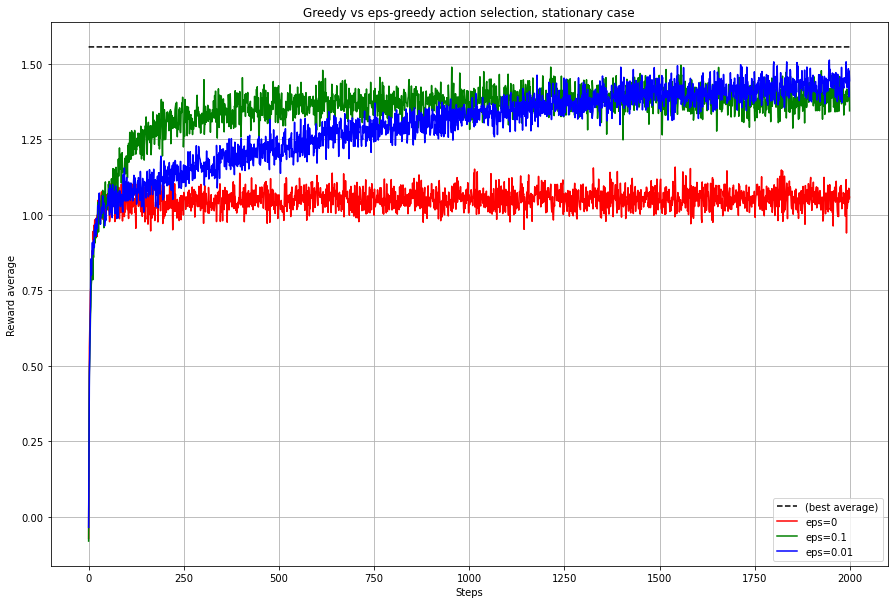

CPU times: user 4min 32s, sys: 344 ms, total: 4min 33s
Wall time: 4min 33s


In [11]:
%%time
steps = 2000
fn_eps_greedy = partial(Bandit.configure, 
                    step_size = "average", step_size_params = None,
                    step_updater = "stationary", step_updater_params = None,
                    init_Q = 0)

for bandit in bandits:
    fn_eps_greedy(bandit, action_selector = "eps_greedy", action_selector_params = None)    
steps_mean_greedy, steps_mean_greedy_best = calculate_rewards_mean_per_step(bandits, steps)

for bandit in bandits:
    fn_eps_greedy(bandit, action_selector = "eps_greedy", action_selector_params = {'eps':0.1})    
steps_mean_greedy_eps_01, _ = calculate_rewards_mean_per_step(bandits, steps)

for bandit in bandits:
    fn_eps_greedy(bandit, action_selector = "eps_greedy", action_selector_params = {'eps':0.01})    
steps_mean_greedy_eps_001, _ = calculate_rewards_mean_per_step(bandits, steps)

plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), steps_mean_greedy_best, 'k--', label="(best average)")
plt.plot(np.arange(steps), steps_mean_greedy, 'r', label="eps=0")
plt.plot(np.arange(steps), steps_mean_greedy_eps_01, 'g', label="eps=0.1")
plt.plot(np.arange(steps), steps_mean_greedy_eps_001, 'b', label="eps=0.01")
draw_plot("Greedy vs eps-greedy action selection, stationary case")


** Run non-stationary eps-greedy bandit with constant step size and with average step size (1/n). **

Step sizes that guarantee convergeness often converge very slowly or need considerable tuning in order to obtain a satisfactory convergence rate.
This example demonstrates that constant estimates never completely converge but
continue to vary in response to the most recently received rewards. As we mentioned
above, this is actually desirable in a nonstationary environment, and problems that are
effectively nonstationary are the most common in reinforcement learning.

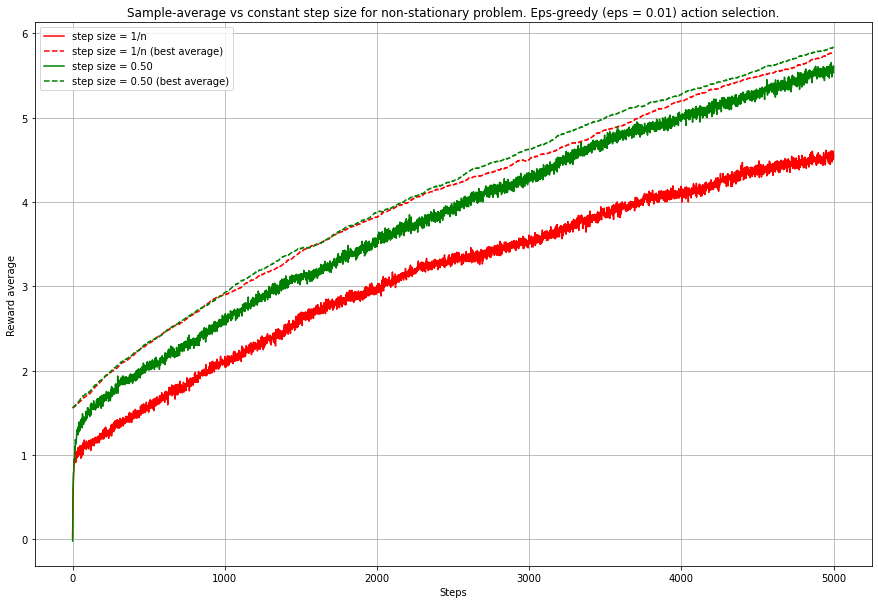

CPU times: user 9min 2s, sys: 452 ms, total: 9min 2s
Wall time: 9min 3s


In [8]:
%%time
steps = 5000
alpha = 0.5
for bandit in bandits:
    bandit.configure(step_size = "average", step_size_params = None,
                    action_selector = "eps_greedy", action_selector_params = {'eps':0.01},
                    step_updater = "non_stationary", step_updater_params = None,
                    init_Q = 0)
steps_mean_ns_eps_greedy, steps_mean_ns_eps_greedy_best = calculate_rewards_mean_per_step(bandits, steps)

for bandit in bandits:
    bandit.configure(step_size = "constant", step_size_params = {'alpha':alpha},
                    action_selector = "eps_greedy", action_selector_params = {'eps':0.01},
                    step_updater = "non_stationary", step_updater_params = None,
                    init_Q = 0)
steps_mean_ns_eps_greedy_const, steps_mean_ns_eps_greedy_const_best = calculate_rewards_mean_per_step(bandits, steps)

plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), steps_mean_ns_eps_greedy, 'r', label="step size = 1/n")
plt.plot(np.arange(steps), steps_mean_ns_eps_greedy_best, 'r--', label="step size = 1/n (best average)")
plt.plot(np.arange(steps), steps_mean_ns_eps_greedy_const, 'g', label=("step size = %.2f" % alpha))
plt.plot(np.arange(steps), steps_mean_ns_eps_greedy_const_best, 'g--',label=("step size = %.2f (best average)" % alpha))
draw_plot("Sample-average vs constant step size for non-stationary problem. Eps-greedy (eps = 0.01) action selection.")

**Run stationary eps-greedy bandit with sample-average step size 1/n and optimistic initial value of Q.**

All the methods we have discussed so far are dependent to some extent on the initial
action-value estimates Q1. In the language of statistics, these methods are biased
by their initial estimates. For the sample-average methods, the bias disappears once all
actions have been selected at least once, but for methods with constant, the bias is
permanent, though decreasing over time. Initial action values can also be used as a simple way to encourage exploration.
Whichever actions are initially selected, the reward is less than the starting estimates; the learner switches to
other actions, being “disappointed” with the rewards it is receiving. The result is that all
actions are tried several times before the value estimates converge. The system does a
fair amount of exploration even if greedy actions are selected all the time. We call this technique for encouraging exploration optimistic initial values. We regard it as
a simple trick that can be quite effective on stationary problems, but it is far from
being a generally useful approach to encouraging exploration. For example, it is not
well suited to nonstationary problems because its drive for exploration is inherently temporary.

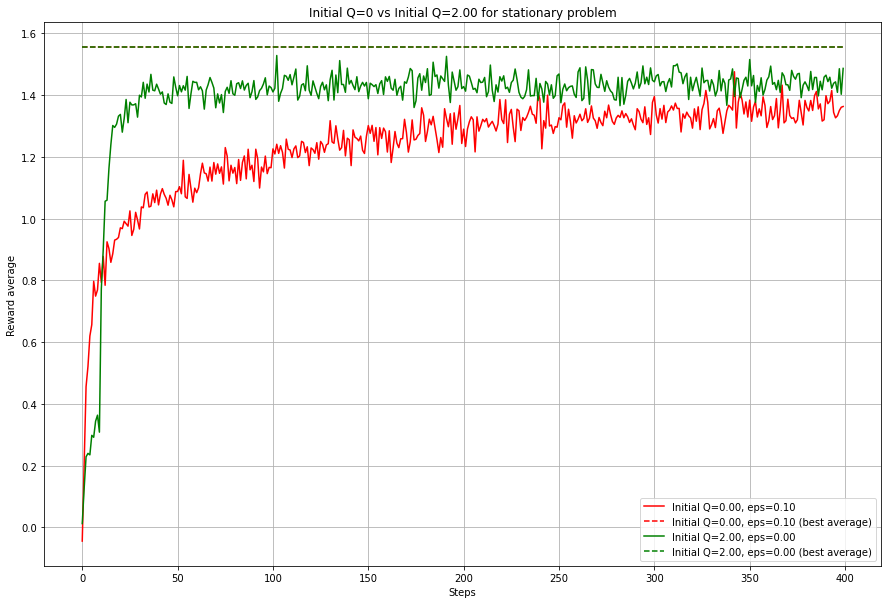

CPU times: user 36.8 s, sys: 47 ms, total: 36.9 s
Wall time: 36.9 s


In [13]:
%%time
steps = 400
eps = 0.1
init_Q = 2

for bandit in bandits:
    bandit.configure(step_size = "average", step_size_params = None,
                    action_selector = "eps_greedy", action_selector_params = {'eps':eps},
                    step_updater = "stationary", step_updater_params = None,
                    init_Q = 0)
steps_mean_eps_greedy, steps_mean_eps_greedy_best = calculate_rewards_mean_per_step(bandits, steps)

for bandit in bandits:
    bandit.configure(step_size = "average", step_size_params = None,
                    action_selector = "eps_greedy", action_selector_params = {'eps':0},
                    step_updater = "stationary", step_updater_params = None,
                    init_Q = init_Q)
steps_mean_eps_greedy_q, steps_mean_eps_greedy_q_best = calculate_rewards_mean_per_step(bandits, steps)

plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), steps_mean_eps_greedy, 'r', label="Initial Q=%.2f, eps=%.2f" % (0, eps))
plt.plot(np.arange(steps), steps_mean_eps_greedy_best, 'r--', label="Initial Q=%.2f, eps=%.2f (best average)" % (0, eps))
plt.plot(np.arange(steps), steps_mean_eps_greedy_q, 'g', label="Initial Q=%.2f, eps=%.2f" % (init_Q, 0))
plt.plot(np.arange(steps), steps_mean_eps_greedy_q_best, 'g--',label="Initial Q=%.2f, eps=%.2f (best average)" % (init_Q, 0))
draw_plot("Initial Q=0 vs Initial Q=%.2f for stationary problem"%init_Q)

**Unbiased Constant-Step-Size Trick.**

Sample
averages are not a completely satisfactory solution because they may perform poorly
on nonstationary problems. Is it possible to avoid the bias of constant step sizes while
retaining their advantages on nonstationary problems

In [ ]:
def const_step_unbiased(alpha, arms):
    o = np.zeros(arms)
    def step(t, action):
        o_n = o[action] + alpha * (1 - o[action])
        o[action] = o_n
        return alpha/o_n
    return step



**Upper-Confidence-Bound Action Selection**

eps-greedy action selection forces the non-greedy
actions to be tried, but indiscriminately, with no preference for those that are nearly
greedy or particularly uncertain. It would be better to select among the non-greedy
actions according to their potential for actually being optimal, taking into account both
how close their estimates are to being maximal and the uncertainties in those estimates.

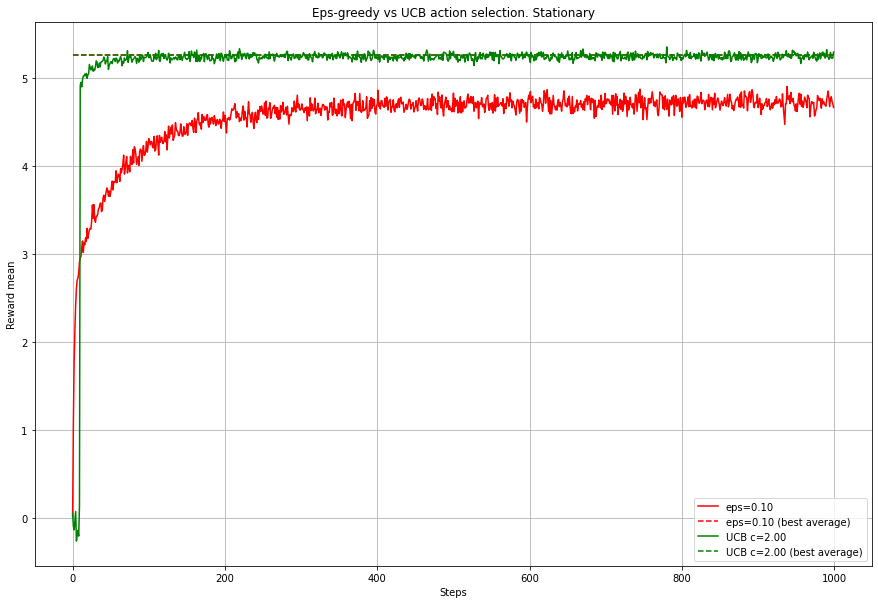

CPU times: user 1min 50s, sys: 216 ms, total: 1min 50s
Wall time: 1min 50s


In [42]:
%%time
steps = 1000
eps = 0.1
c = 2

for bandit in bandits:
    bandit.configure(step_size = "average", step_size_params = None,
                    action_selector = "eps_greedy", action_selector_params = {'eps':eps},
                    step_updater = "stationary", step_updater_params = None,
                    init_Q = 0)
steps_mean_eps_greedy, steps_mean_eps_greedy_best = calculate_rewards_mean_per_step(bandits, steps)

for bandit in bandits:
    bandit.configure(step_size = "average", step_size_params = None,
                    action_selector = "ucb", action_selector_params = {'c':c},
                    step_updater = "stationary", step_updater_params = None,
                    init_Q = 0)
steps_mean_ucb, steps_mean_ucb_best = calculate_rewards_mean_per_step(bandits, steps)

plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), steps_mean_eps_greedy, 'r', label="eps=%.2f"%eps)
plt.plot(np.arange(steps), steps_mean_eps_greedy_best, 'r--', label="eps=%.2f (best average)"%eps)
plt.plot(np.arange(steps), steps_mean_ucb, 'g', label="UCB c=%.2f"%c)
plt.plot(np.arange(steps), steps_mean_ucb_best, 'g--',label="UCB c=%.2f (best average)" % c)
draw_plot("Eps-greedy vs UCB action selection. Stationary")

**Gradient Bandit Algorithms**

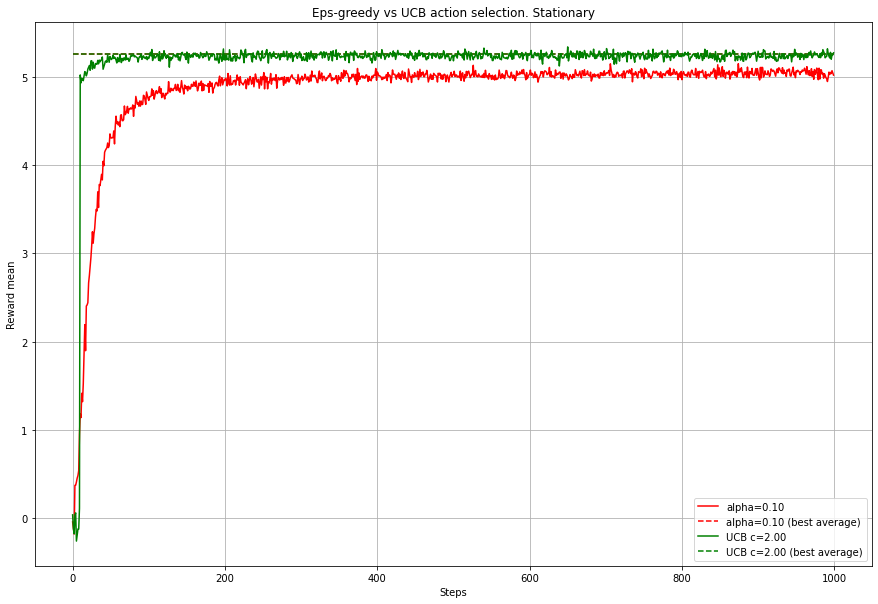

CPU times: user 2min 9s, sys: 297 ms, total: 2min 10s
Wall time: 2min 10s


In [46]:
%%time
steps = 1000
alpha = 0.1
c = 2

for bandit in bandits:
    bandit.configure(step_size = "average", step_size_params = None,
                    action_selector = "ucb", action_selector_params = {'c':c},
                    step_updater = "stationary", step_updater_params = None,
                    init_Q = 0)
steps_mean_ucb, steps_mean_ucb_best = calculate_rewards_mean_per_step(bandits, steps)

for bandit in bandits:
    bandit.configure(step_size = "constant", step_size_params =  {'alpha':alpha},
                    action_selector = "softmax", action_selector_params = None,
                    step_updater = "gradient_stationary", step_updater_params = None,
                    init_Q = 0)
steps_mean_gradient, steps_mean_gradient_best = calculate_rewards_mean_per_step(bandits, steps)

plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), steps_mean_gradient, 'r', label="Gradient alpha=%.2f"%alpha)
plt.plot(np.arange(steps), steps_mean_gradient_best, 'r--', label="Gradient alpha=%.2f (best average)"%alpha)
plt.plot(np.arange(steps), steps_mean_ucb, 'g', label="UCB c=%.2f"%c)
plt.plot(np.arange(steps), steps_mean_ucb_best, 'g--',label="UCB c=%.2f (best average)" % c)
draw_plot("Gradient vs UCB action selection. Stationary")